## Visualize trajectories, detection and equilibrium times for a single set of simulations

In [1]:
import numpy as np
import pandas as pd
import os

from lib.plotting import *
from lib.preferences import *
from lib.response  import *

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import seaborn as sns

# inline stylization
%matplotlib inline
sns.set_style("ticks")
sns.set_style('white')
#sns.set_style("ticks")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [3]:
# Font sizes
plt.rc('font', size=12)         # controls default text sizes
plt.rc('axes', titlesize=14)    # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

## Preferences

In [4]:
analysis_metrics = ["HX", "VX", 
                    'frac_mixed_samples','mean_k',
                    'n_segregating','pi','theta',
                    'avg_frac_ibd', 'avg_n_ibd','avg_l_ibd']

In [5]:
metrics = ["mean_k", "pi", "avg_l_ibd"]

In [6]:
cols = [sns.color_palette("Blues", 6)[4], 
        sns.color_palette("Greens", 6)[4],
        sns.color_palette("Reds", 6)[4]]

In [7]:
genetic_names.update({
    "mean_k": "C.O.I ($k$)",
    "pi": "Nucl. Diversity ($\pi$)",
    "avg_l_ibd": "Avg. IBD\nTrack Length (bp)"
})

In [8]:
savefig = True

## Load data

For each simulation, load and merge.

In [9]:
ixs = [0, 3, 0]  # three that equilibriate < 50yrs
expts = ["art", "bed", "ins"]
temp = "../results/2020-06-07_intv-%s"

In [10]:
ots = []
epoch_dfs = []
ds = []
es = []

for ix, expt in zip(ixs, expts):
    expt_path = temp % expt
    sim_complete = [s for s in os.listdir(expt_path) if "Endpoint" in os.listdir(os.path.join(expt_path, s))]
    n_sims = len(sim_complete)
    
    sim = sim_complete[ix]
    
    # Load full data frame
    epoch_df = pd.read_csv(os.path.join(expt_path, sim, "epoch_df.csv"))
    epoch_df.index = epoch_df.name
    og = pd.read_csv(os.path.join(expt_path, sim, "og.csv"))
    op = pd.read_csv(os.path.join(expt_path, sim, "op.csv"))

    # Merge on time
    ot = pd.merge(left=op, right=og, on="t0")
    
    # Compute statistics
    d = calc_detection_time(ot, epoch_df, 
                            initial_epoch="InitVar", 
                            respond_epoch="Crash", 
                            robustness=3, alpha=0.01,
                            analysis_metrics=analysis_metrics)
    
    e = calc_equilibrium_time(ot, epoch_df,
                              initial_epoch="InitVar", 
                              respond_epoch="Crash",
                              equilibrium_epoch="CrashVar",
                              robustness=6,
                              analysis_metrics=analysis_metrics)
    
    # Store
    ds.append(d)
    es.append(e)
    ots.append(ot)
    epoch_dfs.append(epoch_df)
    
    # Print
    print("Experiment: %s" % expt)
    print("  No. complete: %d" % n_sims)
    print("  Loaded: %s" % sim)

Experiment: art
  No. complete: 98
  Loaded: sim_artemisinin_0071
Experiment: bed
  No. complete: 99
  Loaded: sim_bednets_0003
Experiment: ins
  No. complete: 94
  Loaded: sim_insecticide_0060


## Plot

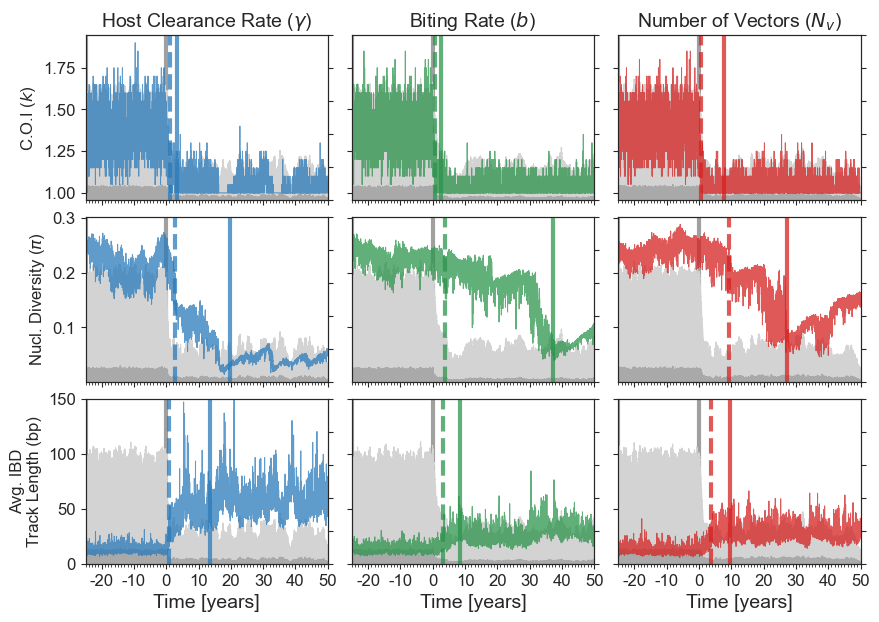

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(10, 7), sharex=True, sharey='row')
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, metric in enumerate(metrics):
    for j, ot in enumerate(ots):

        # Plot
        df = ot.iloc[:-22000]  # trim to make plotting less expensive
        genetic_trajectory_plot(metric, df, epoch_dfs[j],
                                cols[j], ax[i, j],
                                norm_t0=("Crash", "t0"),
                                indicate_epochs=[("Crash", "t0"), ("InitVar", "t0"), ("CrashVar", "t0")],
                                time_limits=epoch_df.loc["InitVar", "t0"] + (0, 75*365),
                                t_detection=ds[j],
                                t_equilibrium=es[j],
                                alpha=0.75,
                                years_per_major_tick=10)
        
        # y-lims
        if metric == "avg_l_ibd":
            ax[i, j].set_ylim((0, 150))
            ax[i, j].set_xlabel("Time [years]")

        # Labels
        if j == 0:
            ax[i, j].set_ylabel(genetic_names[metric], fontsize=12)
        else:
            ax[i, j].set_ylabel("")
            
        
        
        
        
ax[0, 0].set_title("Host Clearance Rate ($\gamma$)")
ax[0, 1].set_title("Biting Rate ($b$)")
ax[0, 2].set_title("Number of Vectors ($N_v$)")

if savefig:
    fig.savefig("../figs/sec3_cf-response-raw.pdf", bbox_inches="tight", pad_inches=0.5)
    fig.savefig("../figs/sec3_cf-response-raw.png", bbox_inches="tight", pad_inches=0.5)

## Load averaged data

In [12]:
temp = "../analysis/2020-06-07_intv-%s"

ots_mu = []
ots_se = []
epoch_dfs = []

for expt in expts:
    # Path
    expt_path = temp % expt
    
    # Load full data
    epoch_df = pd.read_csv(expt_path + "/epoch_df.csv")
    epoch_df.index = epoch_df.name
    op_mu = pd.read_csv(expt_path + "/ops_mean.csv")
    op_se = pd.read_csv(expt_path + "/ops_se.csv")
    og_mu = pd.read_csv(expt_path + "/ogs_mean.csv")
    og_se = pd.read_csv(expt_path + "/ogs_se.csv")
    
    # Merge
    ot_mu = pd.merge(left=op_mu, right=og_mu, on="t0")
    ot_se = pd.merge(left=op_se, right=og_se)
    
    # Store
    ots_mu.append(ot_mu)
    ots_se.append(ot_se)
    epoch_dfs.append(epoch_df)

## Plot averaged

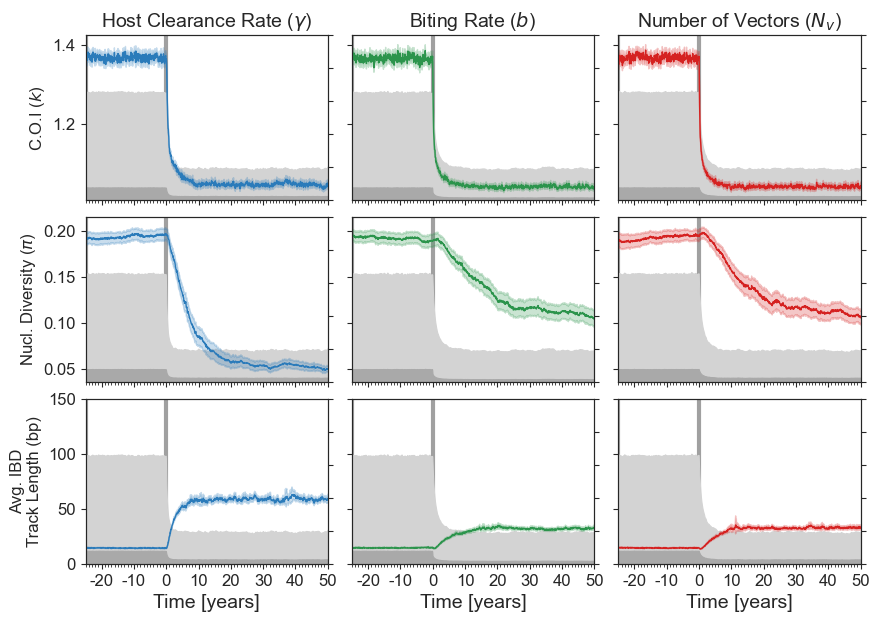

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(10, 7), sharex=True, sharey='row')
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, metric in enumerate(metrics):
    for j, ot_mu in enumerate(ots):
        genetic_trajectory_average_plot(metric, ots_mu[j], ots_se[j], epoch_dfs[j],
                                    cols[j], ax[i, j],
                                    norm_t0=("Crash", "t0"),
                                    indicate_epochs=[("Crash", "t0"), ("InitVar", "t0"), ("CrashVar", "t0")],
                                    time_limits=epoch_df.loc["InitVar", "t0"] + (0, 75*365),
                                    years_per_major_tick=10)
        
        
        # y
        if j == 0:
            ax[i, j].set_ylabel(genetic_names[metric], fontsize=12)
        else:
            ax[i, j].set_ylabel("")
            
        # y-lims
        if metric == "avg_l_ibd":
            ax[i, j].set_ylim((0, 150))
            ax[i, j].set_xlabel("Time [years]")
        
ax[0, 0].set_title("Host Clearance Rate ($\gamma$)")
ax[0, 1].set_title("Biting Rate ($b$)")
ax[0, 2].set_title("Number of Vectors ($N_v$)")

if savefig:
    fig.savefig("../figs/sec3_cf-response-averaged.pdf", bbox_inches="tight", pad_inches=0.5)
    fig.savefig("../figs/sec3_cf-response-averaged.png", bbox_inches="tight", pad_inches=0.5)